# Makemore 2: Multi-Layer Perceptron (MLP)

## Introduction

Implémentation d'un réseau de neurones inspiré du papier de Bengio et al. de 2003 [_A Neural Probabilistic Language Model_](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf).

Rappel: code source de [makemore](https://github.com/karpathy/makemore) d'Andrej Karpathy sur Github.

## Données sources

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('civil_mots.txt', 'r').read().splitlines()
nb_words = len(words)
print("nb_words =", nb_words)

nb_words = 7223


In [3]:
chars = sorted(list(set(''.join(words))))
print(chars)
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
print("nb_chars =", nb_chars)
# Fun fact: il n'y a pas de 'k' dans le code civil

["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
nb_chars = 41


In [4]:
# Dictionnaire permettant de passer d'un caractère à son identifiant entier
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
print("CTOI =", ctoi)
# Dictionnaire permettant permettant de passer d'un entier à son caractère
itoc = {i:s for s,i in ctoi.items()}
print("ITOC =", itoc)
# '.' a l'indice 0

CTOI = {"'": 1, '-': 2, 'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27, 'à': 28, 'â': 29, 'ç': 30, 'è': 31, 'é': 32, 'ê': 33, 'ë': 34, 'î': 35, 'ï': 36, 'ô': 37, 'ù': 38, 'û': 39, 'œ': 40, '.': 0}
ITOC = {1: "'", 2: '-', 3: 'a', 4: 'b', 5: 'c', 6: 'd', 7: 'e', 8: 'f', 9: 'g', 10: 'h', 11: 'i', 12: 'j', 13: 'l', 14: 'm', 15: 'n', 16: 'o', 17: 'p', 18: 'q', 19: 'r', 20: 's', 21: 't', 22: 'u', 23: 'v', 24: 'w', 25: 'x', 26: 'y', 27: 'z', 28: 'à', 29: 'â', 30: 'ç', 31: 'è', 32: 'é', 33: 'ê', 34: 'ë', 35: 'î', 36: 'ï', 37: 'ô', 38: 'ù', 39: 'û', 40: 'œ', 0: '.'}


## Construction du jeu de données pour l'entraînement

In [5]:
def build_dataset(words:list, context_size:int):
    """Build the dataset of the neural net for training.

    Parameters:
        words: list of words of our data corpus
        context_size: how many characters we take to predict the next one

    Returns:
        X: inputs to the neural net
        Y: labels
    """
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * context_size
        for ch in w + '.':
            ix = ctoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itoc[i] for i in context), '--->', itoc[ix])
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    #print(X.shape, Y.shape)
    return X, Y

Les mots du code civil générent un jeu d'entraînement avec les entrées `X` de dimension 2 de forme (67652, 3), soit 67652 contextes de 3 caractères différents et pour les labels `Y` 67652 caractères suivants.

In [6]:
context_size = 3
X, Y = build_dataset(words, context_size)
print("X.shape =", X.shape)
print("Y.shape =", Y.shape)
print(X[:5])
print(Y[:5])

X.shape = torch.Size([67652, 3])
Y.shape = torch.Size([67652])
tensor([[0, 0, 0],
        [0, 0, 3],
        [0, 0, 0],
        [0, 0, 3],
        [0, 3, 4]])
tensor([3, 0, 3, 4, 3])


## Discussion: construction du réseau de neurones

### Matrice d'embeddings C

Cette matrice est ce qui est appelé la _lookup table_ dans [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf). Elle sera de taille `nb_chars, e_dims`, où `nb_chars` est le nombre de caractères différents de notre dataset et `e_dims` le nombre de dimensions que nous choisirons pour représenter chaque caractère dans ce nouvel espace. Nous l'initialisons ici avec des valeurs aléatoires.

In [7]:
e_dims = 2  # Dimensions des embeddings
C = torch.randn((nb_chars, e_dims))
print(C[:5])  # 5 premières lignes

tensor([[ 0.6529,  0.1377],
        [ 0.4876,  0.0775],
        [ 0.1076,  0.3997],
        [-1.1190,  1.6587],
        [ 1.4713,  0.5621]])


Pour utiliser cette "_lookup table_" sous la forme d'une matrice, on peut l'indexer avec le numéro du caractère dont on souhaite obtenir l'embedding:

In [8]:
emb_char_c = C[5]
print(emb_char_c)

tensor([2.2263, 0.0827])


Cette approche est en fait similaire à ce que nous avions fait précédemment avec les vecteurs "one hot":

In [9]:
F.one_hot(torch.tensor(5), num_classes=nb_chars).float()

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.])

In [10]:
F.one_hot(torch.tensor(5), num_classes=nb_chars).float() @ C

tensor([2.2263, 0.0827])

La première couche linéaire de ce réseau de neurones, composé de cette matrice C, va être activée avec les indices des caractères.

L'indexation avec des tenseurs Pytorch est très flexible, ce qui permet de récupérer plusiers lignes, par exemple correspondant à la suite de lettres c, a, b (soit 5,3,4):

In [11]:
C[[5,3,4]]

tensor([[ 2.2263,  0.0827],
        [-1.1190,  1.6587],
        [ 1.4713,  0.5621]])

In [12]:
C[[ctoi['c'], ctoi['a'], ctoi['b']]]

tensor([[ 2.2263,  0.0827],
        [-1.1190,  1.6587],
        [ 1.4713,  0.5621]])

On peut également indexer avec un tenseur:

In [13]:
C[torch.tensor([5,3,4])]

tensor([[ 2.2263,  0.0827],
        [-1.1190,  1.6587],
        [ 1.4713,  0.5621]])

Ce tenseur peut être multi-dimensionnel, comme par exemple `X`:

In [14]:
C[X]

tensor([[[ 0.6529,  0.1377],
         [ 0.6529,  0.1377],
         [ 0.6529,  0.1377]],

        [[ 0.6529,  0.1377],
         [ 0.6529,  0.1377],
         [-1.1190,  1.6587]],

        [[ 0.6529,  0.1377],
         [ 0.6529,  0.1377],
         [ 0.6529,  0.1377]],

        ...,

        [[-0.1202, -0.9563],
         [ 0.3202, -1.2271],
         [-0.2125, -0.8856]],

        [[ 0.3202, -1.2271],
         [-0.2125, -0.8856],
         [ 0.2423,  0.2251]],

        [[-0.2125, -0.8856],
         [ 0.2423,  0.2251],
         [-0.2125, -0.8856]]])

In [15]:
C[X].shape

torch.Size([67652, 3, 2])

Ce qui nous permet de créer tous les embeddings:

In [16]:
emb = C[X]

### Discussion sur la couche cachée

La couche cachée sera composée d'une couche avec `context_size * e_dims` entrées et un nombre de neurones à définir (prenons ici 100), avec pour chaque neurone un poids et un biais, poids et biais qui seront définis dans un matrice `W1` et un vecteur `b1`:

In [17]:
W1 = torch.randn((context_size*e_dims, 100))
b1 = torch.randn(100)
W1.shape, b1.shape

(torch.Size([6, 100]), torch.Size([100]))

Nous souhaiterions donc maintenant multiplier les entrées par les poids et ajouter les biais:

In [18]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (202956x2 and 6x100)

Ce qui ne fonctionne pas, car les dimensions ne sont pas correctes. Il faudrait passer pour `emb` d'une forme `[67652, 3, 2]` à une forme `[67652, 6]`. On peut le faire en concaténant en dimension 1 avec [`cat`](https://pytorch.org/docs/main/generated/torch.cat.html): 

In [19]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([67652, 6])

Mais cette approche n'est pas très propre car difficilement généralisable. On peut également utiliser [`unbind`](https://pytorch.org/docs/stable/generated/torch.unbind.html) qui est plus simple:

In [20]:
torch.cat(torch.unbind(emb, 1), 1).shape

torch.Size([67652, 6])

Mais il y a une approche plus efficace consistant à utiliser la méthode [`view()`](https://pytorch.org/docs/stable/generated/torch.Tensor.view.html) d'un tenseur, permettant de "réorganiser" les éléments d'un tenseur selon différentes formes et dimensions, à condition que le nombre d'éléments soit identique:

In [21]:
a = torch.arange(18)
a

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17])

In [22]:
a.shape

torch.Size([18])

In [23]:
a.view(2, 9)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16, 17]])

In [24]:
a.view(9, 2)

tensor([[ 0,  1],
        [ 2,  3],
        [ 4,  5],
        [ 6,  7],
        [ 8,  9],
        [10, 11],
        [12, 13],
        [14, 15],
        [16, 17]])

In [25]:
a.view(3, 3, 2)

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]],

        [[12, 13],
         [14, 15],
         [16, 17]]])

In [26]:
a.storage()

/var/folders/f3/nrzvpdb51b7f_cd_50qlhsvr0000gn/T/ipykernel_7932/214256462.py:1: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  a.storage()


 0
 1
 2
 3
 4
 5
 6
 7
 8
 9
 10
 11
 12
 13
 14
 15
 16
 17
[torch.storage.TypedStorage(dtype=torch.int64, device=cpu) of size 18]

In [27]:
emb.view(67652, 6)

tensor([[ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        [ 0.6529,  0.1377,  0.6529,  0.1377, -1.1190,  1.6587],
        [ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        ...,
        [-0.1202, -0.9563,  0.3202, -1.2271, -0.2125, -0.8856],
        [ 0.3202, -1.2271, -0.2125, -0.8856,  0.2423,  0.2251],
        [-0.2125, -0.8856,  0.2423,  0.2251, -0.2125, -0.8856]])

In [28]:
emb.view(-1, 6)

tensor([[ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        [ 0.6529,  0.1377,  0.6529,  0.1377, -1.1190,  1.6587],
        [ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        ...,
        [-0.1202, -0.9563,  0.3202, -1.2271, -0.2125, -0.8856],
        [ 0.3202, -1.2271, -0.2125, -0.8856,  0.2423,  0.2251],
        [-0.2125, -0.8856,  0.2423,  0.2251, -0.2125, -0.8856]])

In [29]:
emb.view(-1, context_size*e_dims)

tensor([[ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        [ 0.6529,  0.1377,  0.6529,  0.1377, -1.1190,  1.6587],
        [ 0.6529,  0.1377,  0.6529,  0.1377,  0.6529,  0.1377],
        ...,
        [-0.1202, -0.9563,  0.3202, -1.2271, -0.2125, -0.8856],
        [ 0.3202, -1.2271, -0.2125, -0.8856,  0.2423,  0.2251],
        [-0.2125, -0.8856,  0.2423,  0.2251, -0.2125, -0.8856]])

Nous pouvons maintenant implémenter la couche caché complètement:

In [30]:
h = torch.tanh(emb.view(-1, context_size*e_dims) @ W1 + b1)
h

tensor([[ 0.8779, -0.8752,  0.6153,  ...,  0.1436,  0.5931, -0.9808],
        [ 0.9814, -0.9967, -0.3594,  ...,  0.9177, -0.7803,  0.9096],
        [ 0.8779, -0.8752,  0.6153,  ...,  0.1436,  0.5931, -0.9808],
        ...,
        [ 0.9968,  0.9763,  0.9560,  ..., -0.9180, -0.9922,  0.1634],
        [ 1.0000,  0.2808,  0.9729,  ..., -0.5634, -0.3961,  0.8940],
        [ 0.7209,  0.9595,  0.7724,  ...,  0.6519, -0.9857,  0.7349]])

### Couche de sortie

In [31]:
W2 = torch.randn((100, nb_chars))
b2 = torch.randn(nb_chars)
W2.shape, b2.shape

(torch.Size([100, 41]), torch.Size([41]))

In [32]:
logits = h @ W2 + b2
logits.shape

torch.Size([67652, 41])

In [33]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)

In [34]:
prob[0].sum()

tensor(1.0000)

In [35]:
prob[torch.arange(Y.size(0)), Y]

tensor([6.0919e-11, 7.9578e-03, 6.0919e-11,  ..., 4.7874e-11, 1.9562e-03,
        1.8599e-10])

In [36]:
loss = -prob[torch.arange(Y.size(0)), Y].log().mean()
loss

tensor(17.1219)

La methode [`cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html) de Pytorch permet de calculer plus efficacement le loss:

In [37]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.1219)

## Réseau complet et entraînement

### Architecture

In [38]:
e_dims = 10  # Dimensions des embeddings
print("nb_chars =", nb_chars)
print("e_dims =", e_dims)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((nb_chars, e_dims), generator=g)
W1 = torch.randn((context_size*e_dims, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, nb_chars), generator=g)
b2 = torch.randn(nb_chars, generator=g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

nb_chars = 41
e_dims = 10


In [39]:
sum(p.nelement() for p in parameters) # number of parameters in total

14851

### Jeux d'entraînement, de développement et de test

In [40]:
# 80%, 10%, 10%
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

context_size = 3
Xtr, Ytr = build_dataset(words[:n1], context_size=context_size)
Xdev, Ydev = build_dataset(words[n1:n2], context_size=context_size)
Xte, Yte = build_dataset(words[n2:], context_size=context_size)

### Entraînement

In [41]:
lossi = []
stepi = []

In [42]:
for i in range(200000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
    # forward pass
    emb = C[Xtr[ix]] # (32, context_size, e_dims)
    h = torch.tanh(emb.view(-1, context_size*e_dims) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, nb_chars)
    loss = F.cross_entropy(logits, Ytr[ix])
    #print(loss.item())
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

#print(loss.item())

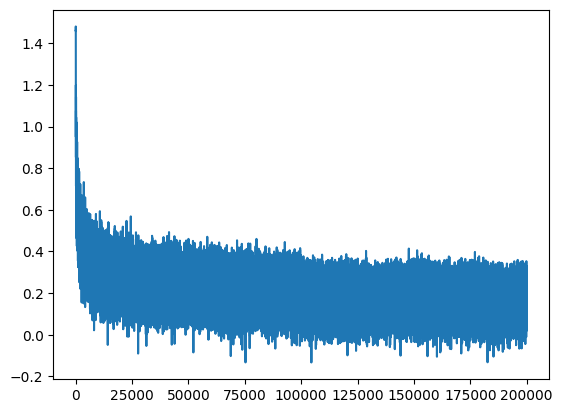

In [43]:
plt.plot(stepi, lossi)

In [44]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_size*e_dims) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, nb_chars)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(1.5031, grad_fn=<NllLossBackward0>)

In [45]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, context_size*e_dims) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, nb_chars)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(1.7257, grad_fn=<NllLossBackward0>)

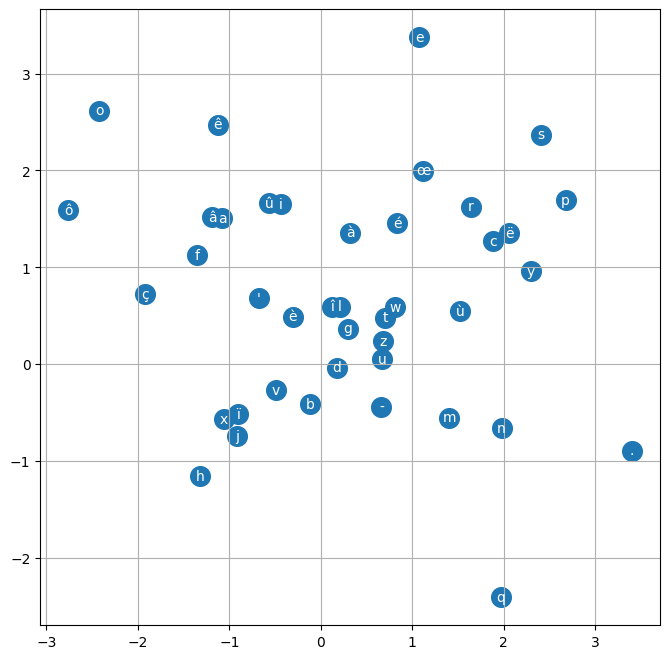

In [46]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itoc[i], ha="center", va="center", color='white')
plt.grid('minor')

## Utilisation du modèle: génération de mots

In [47]:
context = [0] * context_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [48]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * context_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, context_size, e_dims)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itoc[i] for i in out))

aves.
défester.
pièces.
sociale.
apprétaire.
succeplément.
mes.
trouvoire.
assuu.
tuteurressorts.
momplies.
justitualité.
exprive.
herces.
délégales.
memblateurt.
résent.
qu'aucunt.
pe.
norement.


```
aves.
défester.
pièces.
sociale.
apprétaire.
succeplément.
mes.
trouvoire.
assuu.
tuteurressorts.
momplies.
justitualité.
exprive.
herces.
délégales.
memblateurt.
résent.
qu'aucunt.
pe.
norement.
```